In [1]:
import nibabel as nib
import numpy as np
import os

# Define the path to the tractograms to evaluate
results_path = "/media/hsa22/Expansion/deeplearning_test/test/test/brain_A6Vb-R01_0104-TT72/regression_points_directions/batch_0"
optimized_path = os.path.join(results_path, "track.trk")
model_path = os.path.join(results_path, "tracer_decoded_restored.trk")
original_path = os.path.join(results_path, "tracer_streamlines_restored.trk")

In [2]:
# Load up the tractograms
optimized_tractogram = nib.streamlines.load(optimized_path)
model_tractogram = nib.streamlines.load(model_path)
original_tractogram = nib.streamlines.load(original_path)

# Get the streamlines
optimized_streamlines = optimized_tractogram.streamlines
model_streamlines = model_tractogram.streamlines
original_streamlines = original_tractogram.streamlines

# Print the number of streamlines
print("Number of streamlines in the optimized tractogram: {}".format(len(optimized_streamlines)))
print("Number of streamlines in the model tractogram: {}".format(len(model_streamlines)))
print("Number of streamlines in the original tractogram: {}".format(len(original_streamlines)))

Number of streamlines in the optimized tractogram: 20627
Number of streamlines in the model tractogram: 68751
Number of streamlines in the original tractogram: 68751


In [ ]:
import numpy as np
import nibabel as nib
from dipy.viz import window, actor

# Define the number of streamlines to visualize
model_subset = model_streamlines
original_subset = original_streamlines

# Create a rendering scene
scene = window.Scene()

# Add the model streamlines (shown in red)
model_actor = actor.streamtube(model_subset, colors=(1, 0, 0), opacity=0.5, linewidth=0.3)
scene.add(model_actor)

# Add the original streamlines (shown in green)
original_actor = actor.streamtube(original_subset, colors=(0, 1, 0), opacity=0.5, linewidth=0.3)
scene.add(original_actor)

# Adjust the camera settings if needed
scene.reset_camera()
scene.reset_clipping_range()

# Display the scene
window.show(scene)


In [13]:
import numpy as np
import nibabel as nib
from dipy.viz import window, actor
from dipy.tracking.distances import bundles_distances_mdf
import fury.ui as ui

# Assuming model_streamlines and original_streamlines are loaded in memory
num_streamlines = 10000
model_subset = model_streamlines[:num_streamlines]
original_subset = original_streamlines[:num_streamlines]

# Compute the mean distance between each streamline in model_subset and all streamlines in original_subset
mean_distances = np.mean(bundles_distances_mdf(model_subset, original_subset), axis=1)

# Select streamlines from model_subset that have a mean distance greater than a threshold (indicating a significant difference)
threshold = 5  # Adjust based on your data and what you consider a "significant" difference
different_streamlines = [model_subset[i] for i, d in enumerate(mean_distances) if d > threshold]

# Create a rendering scene
scene = window.Scene()

# Add the "different" streamlines (shown in red)
diff_actor = actor.streamtube(different_streamlines, colors=(1, 0, 0), linewidth=0.3)
scene.add(diff_actor)

# Add the original streamlines (shown in green for reference)
original_actor = actor.streamtube(original_subset, colors=(0, 1, 0), opacity=0.5, linewidth=0.3)
scene.add(original_actor)

# Add coordinate axes for orientation (X: red, Y: green, Z: blue)
axes_actor = actor.axes()
scene.add(axes_actor)

# Adjust the camera settings if needed
scene.reset_camera()
scene.reset_clipping_range()

# Display the scene
window.show(scene)

/tmp/ipykernel_868729/3303335374.py:13: UserWarning: Streamlines do not have the same number of points. All streamlines need to have the same number of points. Use dipy.tracking.streamline.set_number_of_points to adjust your streamlines
  mean_distances = np.mean(bundles_distances_mdf(model_subset, original_subset), axis=1)


In [14]:
# Find the mean and standard deviation of the mean distances
mean = np.mean(mean_distances)
std = np.std(mean_distances)

# Print the mean and standard deviation
print("Mean of residuals: {}".format(mean))
print("Standard deviation of residuals: {}".format(std))

Mean of residuals: 4.554808174763661
Standard deviation of residuals: 0.8756507066773486


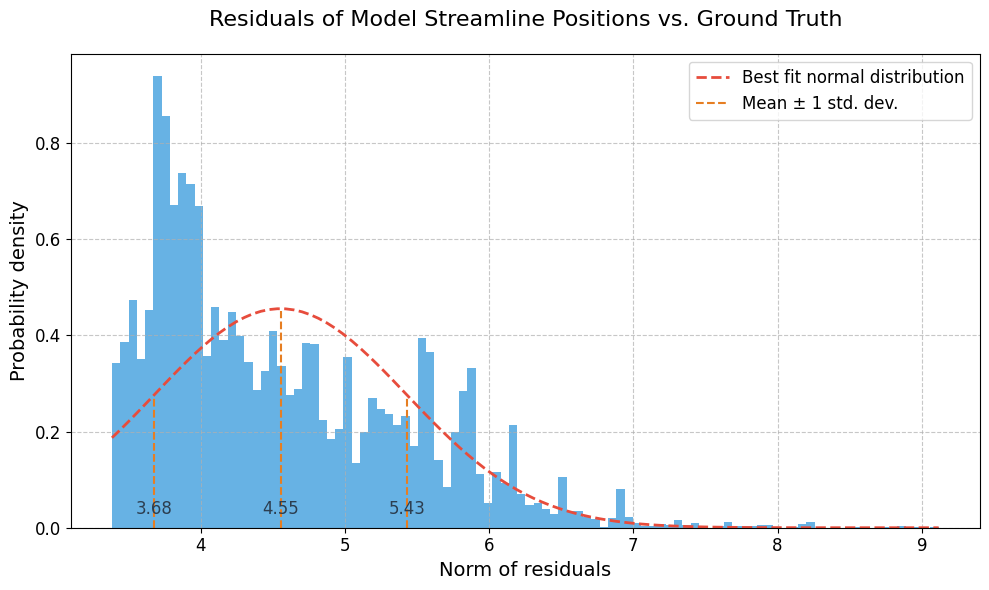

In [20]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Soft color palette
hist_color = '#3498db'  # blue
line_color = '#e74c3c'  # red
mean_color = '#2c3e50'  # dark gray
annotation_color = '#e67e22'  # orange

# Histogram of residuals
n, bins, patches = ax.hist(mean_distances, bins=100, density=True, color=hist_color, alpha=0.75)

# Add a 'best fit' line
y = norm.pdf(bins, mean, std)
ax.plot(bins, y, '--', color=line_color, linewidth=2, label='Best fit normal distribution')

# Add vertical lines for the mean and one standard deviation on either side
ax.vlines(mean, 0, 0.45, color=annotation_color, linestyle='dashed', linewidth=1.5)
ax.vlines(mean + std, 0, 0.27, color=annotation_color, linestyle='dashed', linewidth=1.5, label='Mean ± 1 std. dev.')
ax.vlines(mean - std, 0, 0.27, color=annotation_color, linestyle='dashed', linewidth=1.5)

# Annotate the mean and std values on the x-axis
ax.annotate(f'{mean:.2f}', (mean, 0), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color=mean_color)
ax.annotate(f'{mean + std:.2f}', (mean + std, 0), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color=mean_color)
ax.annotate(f'{mean - std:.2f}', (mean - std, 0), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color=mean_color)

# Improve labels and title
ax.set_xlabel('Norm of residuals', fontsize=14)
ax.set_ylabel('Probability density', fontsize=14)
ax.set_title('Residuals of Model Streamline Positions vs. Ground Truth', fontsize=16, pad=20)

# Adding a grid for better readability
ax.grid(True, linestyle='--', which='both', alpha=0.7, zorder=0)

# Position the legend optimally and set its fontsize
ax.legend(loc='upper right', fontsize=12)

# Increase tick font size
ax.tick_params(axis='both', labelsize=12)

# Ensure everything fits without clipping
fig.tight_layout()

# Display the plot
plt.show()

In [18]:
# Find the residuals between the model and original tractograms
residuals = []
for i in range(len(original_streamlines)):
    residuals.append(np.linalg.norm(np.array(original_streamlines[i][:39]) - np.array(model_streamlines[i])))

# Convert the residuals to a numpy array
residuals = np.array(residuals)

# Get the mean and standard deviation of the residuals
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)

# Print the mean and standard deviation of the residuals
print("Mean of residuals: {}".format(np.mean(residuals)))
print("Standard deviation of residuals: {}".format(np.std(residuals)))

Mean of residuals: 1.8848499059677124
Standard deviation of residuals: 0.7634130716323853


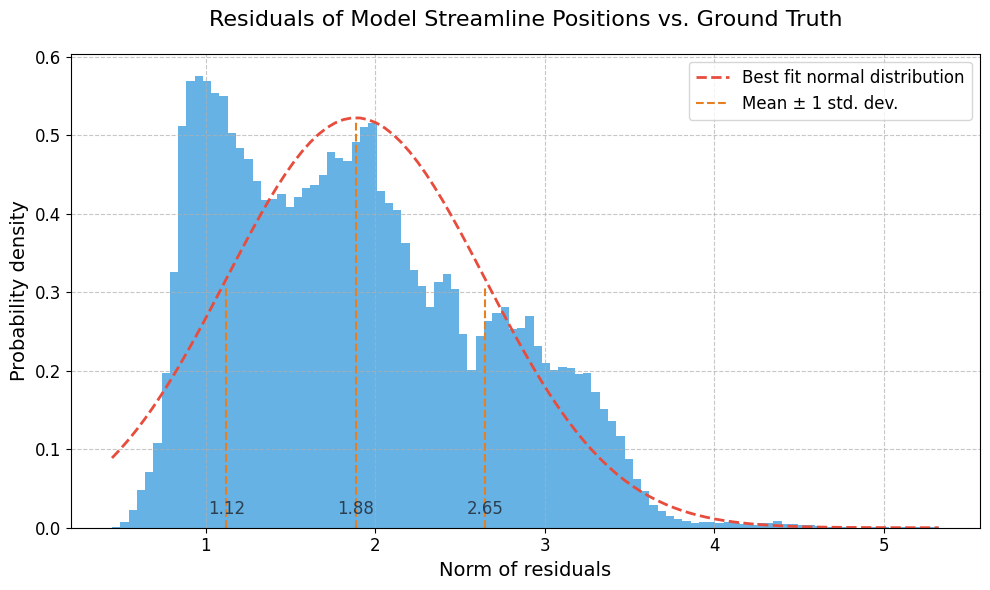

In [56]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Sample data (assuming you have these values in your original code)
# residuals, mean_residuals, std_residuals

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Soft color palette
hist_color = '#3498db'  # blue
line_color = '#e74c3c'  # red
mean_color = '#2c3e50'  # dark gray
annotation_color = '#e67e22'  # orange

# Histogram of residuals
n, bins, patches = ax.hist(residuals, bins=100, density=True, color=hist_color, alpha=0.75)

# Add a 'best fit' line
y = norm.pdf(bins, mean_residuals, std_residuals)
ax.plot(bins, y, '--', color=line_color, linewidth=2, label='Best fit normal distribution')

# Add vertical lines for the mean and one standard deviation on either side
ax.vlines(mean_residuals, 0, 0.52, color=annotation_color, linestyle='dashed', linewidth=1.5)
ax.vlines(mean_residuals + std_residuals, 0, 0.31, color=annotation_color, linestyle='dashed', linewidth=1.5, label='Mean ± 1 std. dev.')
ax.vlines(mean_residuals - std_residuals, 0, 0.31, color=annotation_color, linestyle='dashed', linewidth=1.5)

# Annotate the mean and std values on the x-axis
ax.annotate(f'{mean_residuals:.2f}', (mean_residuals, 0), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color=mean_color)
ax.annotate(f'{mean_residuals + std_residuals:.2f}', (mean_residuals + std_residuals, 0), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color=mean_color)
ax.annotate(f'{mean_residuals - std_residuals:.2f}', (mean_residuals - std_residuals, 0), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color=mean_color)

# Improve labels and title
ax.set_xlabel('Norm of residuals', fontsize=14)
ax.set_ylabel('Probability density', fontsize=14)
ax.set_title('Residuals of Model Streamline Positions vs. Ground Truth', fontsize=16, pad=20)

# Adding a grid for better readability
ax.grid(True, linestyle='--', which='both', alpha=0.7, zorder=0)

# Position the legend optimally and set its fontsize
ax.legend(loc='upper right', fontsize=12)

# Increase tick font size
ax.tick_params(axis='both', labelsize=12)

# Ensure everything fits without clipping
fig.tight_layout()

# Display the plot
plt.show()
